In [29]:
import os
print(os.getcwd())

C:\Users\DWWillson\Desktop\CAISO Monthly Prices


# Overview
We define a function on concatenated (CAISO) monthly price files which:

(a) plots the daily average price for a "Sensible" strategy of charging for two hours at the onset of the Off-Peak Period,
    versus the average for a "Clever" strategy of choosing the two hours with the lowest. 
    This sets an upper bound for the savings 
    An actual implementation might choose periods based on the DAM prices from 1pm the prior day modified by updated weather conditions, and

(b) compares the mean price for each strategy for each month, and computes the percentage savings.

A separate issue is whether any price spikes occured, which we should check for!

# Approach
We first place the subject files in a Python list, and then read them via a list comprehension, whereupon they are concatenated (for example to compile a complete and continuous year, so that seasonal factors may be deemed less of an issue).
This is plotted for review.
Next the two hours at the onset of Off-Peak Pricing are carved out (dfm),
and the mean daily price computed pursuant to a groupby() on 'day' (Sensible strategy).
Then the "wee" hours from midnight to 6am are carved out (dfw) and the mean daily price is computed based on the lowest two hours, again via a groupby() on 'day'.


# Insights
This analysis seems to be saying that there are potential cost savings of 24-XX% for Level One & Level Two charging respectively). However, my personal sense is that other grids, such as MISO, which have relatively higher amounts of Wind generation (and occoasional negative nighttime prices), may offer even larger savings. While we do not have 5-minute data 
 for MISO, we do have hourly data and so one approach is to compare the hourly standard deviation of prices. From this an extraplotation to 5-minute standard deviation can be inferred. Potential savings from opportunistic charging may then be obtained from silulations.

In [1]:
import pandas as pd
df= pd.read_csv('DAM_Jan_2019.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 16 columns):
INTERVALSTARTTIME_GMT    2976 non-null object
INTERVALENDTIME_GMT      2976 non-null object
OPR_DT                   2976 non-null object
OPR_HR                   2976 non-null int64
OPR_INTERVAL             2976 non-null int64
NODE_ID_XML              2976 non-null object
NODE_ID                  2976 non-null object
NODE                     2976 non-null object
MARKET_RUN_ID            2976 non-null object
LMP_TYPE                 2976 non-null object
XML_DATA_ITEM            2976 non-null object
PNODE_RESMRID            2976 non-null object
GRP_TYPE                 2976 non-null object
POS                      2976 non-null int64
MW                       2976 non-null float64
GROUP                    2976 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 372.1+ KB


In [3]:
df.head()

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,OPR_INTERVAL,NODE_ID_XML,NODE_ID,NODE,MARKET_RUN_ID,LMP_TYPE,XML_DATA_ITEM,PNODE_RESMRID,GRP_TYPE,POS,MW,GROUP
0,2019-01-02T05:00:00-00:00,2019-01-02T06:00:00-00:00,1/1/2019,22,0,TH_NP15_GEN-APND,TH_NP15_GEN-APND,TH_NP15_GEN-APND,DAM,LMP,LMP_PRC,TH_NP15_GEN-APND,ALL_APNODES,0,50.58543,1
1,2019-01-02T07:00:00-00:00,2019-01-02T08:00:00-00:00,1/1/2019,24,0,TH_NP15_GEN-APND,TH_NP15_GEN-APND,TH_NP15_GEN-APND,DAM,LMP,LMP_PRC,TH_NP15_GEN-APND,ALL_APNODES,0,45.04523,1
2,2019-01-02T04:00:00-00:00,2019-01-02T05:00:00-00:00,1/1/2019,21,0,TH_NP15_GEN-APND,TH_NP15_GEN-APND,TH_NP15_GEN-APND,DAM,LMP,LMP_PRC,TH_NP15_GEN-APND,ALL_APNODES,0,53.25076,1
3,2019-01-01T22:00:00-00:00,2019-01-01T23:00:00-00:00,1/1/2019,15,0,TH_NP15_GEN-APND,TH_NP15_GEN-APND,TH_NP15_GEN-APND,DAM,LMP,LMP_PRC,TH_NP15_GEN-APND,ALL_APNODES,0,22.00497,1
4,2019-01-01T16:00:00-00:00,2019-01-01T17:00:00-00:00,1/1/2019,9,0,TH_NP15_GEN-APND,TH_NP15_GEN-APND,TH_NP15_GEN-APND,DAM,LMP,LMP_PRC,TH_NP15_GEN-APND,ALL_APNODES,0,35.99172,1


In [1]:
# files= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv','DAM_June_2018.csv','DAM_July_2018.csv','DAM_Aug_2018.csv','DAM_Sept_2018.csv','DAM_Oct_2018.csv','DAM_Nov_2018.csv','DAM_Dec_2018.csv']
# files= ['DAM_Jan_2019.csv']

files= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv','DAM_June_2018.csv']

frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT') for file in files]
df1= pd.concat(frames)
dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby SPECIFY FORMAT!!
dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
dfp.columns= ['hour','price','day']
dfp['weekday']= dfp.day.dt.weekday_name
dfp['month']= dfp.day.dt.month #new code
dfp.index.names= ['date']
dfp.info()
dfp.head()

NameError: name 'pd' is not defined

C:\Users\DWWillson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
dfp.info() # as desired, the date is now the DateTime object (perfect for time series plotting)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2019-01-02 05:00:00 to 2019-02-01 04:00:00
Data columns (total 5 columns):
OPR_DT      744 non-null object
OPR_HR      744 non-null int64
LMP_TYPE    744 non-null object
MW          744 non-null float64
date        744 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 34.9+ KB


In [10]:
dfp.head()
dfp.tail()

,OPR_DT,OPR_HR,LMP_TYPE,MW,date
INTERVALSTARTTIME_GMT,,,,,
2019-01-31 20:00:00,1/31/2019,13,LMP,36.49414,2019-01-31
2019-02-01 01:00:00,1/31/2019,18,LMP,59.88980,2019-01-31
2019-02-01 03:00:00,1/31/2019,20,LMP,53.29588,2019-01-31
2019-01-31 11:00:00,1/31/2019,4,LMP,36.02188,2019-01-31
2019-02-01 04:00:00,1/31/2019,21,LMP,48.09075,2019-01-31


In [11]:


dfp.head() # 

,hour,price,day,weekday,month
date,,,,,
2019-01-02 05:00:00,22,50.58543,2019-01-01,Tuesday,1
2019-01-02 07:00:00,24,45.04523,2019-01-01,Tuesday,1
2019-01-02 04:00:00,21,53.25076,2019-01-01,Tuesday,1
2019-01-01 22:00:00,15,22.00497,2019-01-01,Tuesday,1
2019-01-01 16:00:00,9,35.99172,2019-01-01,Tuesday,1


In [12]:
dfp.tail()

,hour,price,day,weekday,month
date,,,,,
2019-01-31 20:00:00,13,36.49414,2019-01-31,Thursday,1
2019-02-01 01:00:00,18,59.88980,2019-01-31,Thursday,1
2019-02-01 03:00:00,20,53.29588,2019-01-31,Thursday,1
2019-01-31 11:00:00,4,36.02188,2019-01-31,Thursday,1
2019-02-01 04:00:00,21,48.09075,2019-01-31,Thursday,1


In [13]:
dfp.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2019-01-02 05:00:00 to 2019-02-01 04:00:00
Data columns (total 5 columns):
hour       744 non-null int64
price      744 non-null float64
day        744 non-null datetime64[ns]
weekday    744 non-null object
month      744 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 34.9+ KB


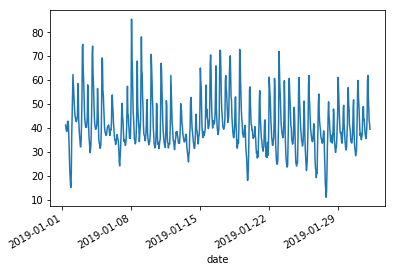

In [15]:
import matplotlib.pyplot as plt # hourly DAM prices are more stable that RTM 5-minute market
dfp['price'].plot()
plt.show()

In [16]:
gp= dfp.groupby('hour')# unable to also groupbt month:  'month', axis=0
# gp.shape  NB unclear whether this is the STD of hourly average, or of 5-minute prices within that hour? (Do a test?)

In [17]:
gp['price'].mean()

hour
1     37.219082
2     36.031534
3     35.072111
4     35.458791
5     37.135136
6     40.606037
7     48.505247
8     48.197871
9     39.448622
10    36.030400
11    33.225216
12    31.183810
13    29.338003
14    30.547777
15    31.919598
16    37.799474
17    46.592750
18    62.115051
19    61.524250
20    54.828971
21    49.450280
22    44.648687
23    40.884123
24    38.425558
Name: price, dtype: float64

In [18]:
gp['price'].std() #much lower than for RTM 5-minute (eg for 6pm Hour 18, sd was > 130)

hour
1     2.904752
2     2.976088
3     3.162970
4     3.068273
5     2.804504
6     2.778257
7     7.107654
8     8.776341
9     5.613834
10    6.840400
11    7.019194
12    7.003610
13    7.154660
14    7.086719
15    6.117861
16    4.417177
17    7.164000
18    9.748296
19    7.340425
20    6.272300
21    4.969220
22    4.287332
23    3.218588
24    2.795093
Name: price, dtype: float64

In [19]:
gp['price'].std() 
# this shows that hours 3,4 & 5 have relatively little variation (is coal on the margin?- not much Wind?) Can import Coal??
# This implies that the benefits of "opportunistic charging" may be relatively limited, if hours 3-5 were chosen as the default, 
# rather than from midnight to 2am
# But this might change with the new MISO transmission interconnection?

hour
1     2.904752
2     2.976088
3     3.162970
4     3.068273
5     2.804504
6     2.778257
7     7.107654
8     8.776341
9     5.613834
10    6.840400
11    7.019194
12    7.003610
13    7.154660
14    7.086719
15    6.117861
16    4.417177
17    7.164000
18    9.748296
19    7.340425
20    6.272300
21    4.969220
22    4.287332
23    3.218588
24    2.795093
Name: price, dtype: float64

In [20]:
one_am= dfp[dfp.hour== 1]
one_am.price.mean()


37.219081612903224

In [21]:
one_am.price.std() 
# this and the mean above match the groupby() exactly

2.9047518432310158

In [22]:
dfm= dfp[(dfp.hour.isin([24,1]))] #dfm is the two hours immediately at the onset of full Off-Peak


In [23]:
dfm.head()

,hour,price,day,weekday,month
date,,,,,
2019-01-02 07:00:00,24,45.04523,2019-01-01,Tuesday,1
2019-01-01 08:00:00,1,41.17931,2019-01-01,Tuesday,1
2019-01-03 07:00:00,24,43.32988,2019-01-02,Wednesday,1
2019-01-02 08:00:00,1,44.15079,2019-01-02,Wednesday,1
2019-01-04 07:00:00,24,42.03837,2019-01-03,Thursday,1


In [24]:
gm= dfm.groupby('day')
gm

In [25]:
sprice= gm.price.mean() # sprice is Sensible Strategy average for the day
sprice[0:10]

day
2019-01-01    43.112270
2019-01-02    43.740335
2019-01-03    41.875435
2019-01-04    40.599620
2019-01-05    37.614365
2019-01-06    34.625565
2019-01-07    37.171345
2019-01-08    36.406520
2019-01-09    37.187725
2019-01-10    35.099600
Name: price, dtype: float64

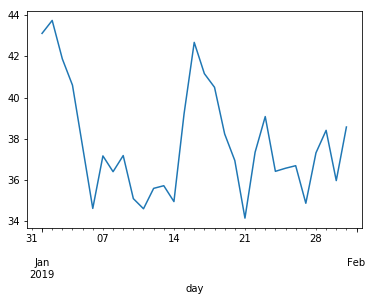

In [27]:
sprice.plot()

In [28]:
# dfp.price.plot(kind='hist', bins=20) # the outliers at 1000 (50x the normal price) spoil the display


In [29]:
# dfp.boxplot(column= 'price', by= 'hour')


In [30]:
# dfc= dfp[(dfp.hour.isin([list(range(1,7))]))]

dfc= dfp[(dfp.hour.isin(list(range(1,7))))]
dfc.tail(2)


,hour,price,day,weekday,month
date,,,,,
2019-01-31 10:00:00,3,35.02910,2019-01-31,Thursday,1
2019-01-31 11:00:00,4,36.02188,2019-01-31,Thursday,1


In [31]:
dfc= dfp[(dfp.hour.isin([1,2,3,4,5,6]))] #dfc is for the Clever strategy , all six hours


In [32]:
dfc.tail(2)

,hour,price,day,weekday,month
date,,,,,
2019-01-31 10:00:00,3,35.02910,2019-01-31,Thursday,1
2019-01-31 11:00:00,4,36.02188,2019-01-31,Thursday,1


In [33]:
gc2price= dfc.groupby('day')['price'].nsmallest(2)

In [34]:
gc2price[0:30] # Hmmm. we have 24 prices but they are not in our 6 our window! But Datetimes are GMT so add 8 hours!!

day         date               
2019-01-01  2019-01-01 11:00:00    38.49406
            2019-01-01 10:00:00    38.70478
2019-01-02  2019-01-02 10:00:00    42.60384
            2019-01-02 11:00:00    42.93449
2019-01-03  2019-01-03 11:00:00    40.18602
            2019-01-03 09:00:00    40.32422
2019-01-04  2019-01-04 10:00:00    39.42497
            2019-01-04 09:00:00    39.45404
2019-01-05  2019-01-05 10:00:00    36.95764
            2019-01-05 12:00:00    37.04088
2019-01-06  2019-01-06 10:00:00    33.04277
            2019-01-06 11:00:00    33.57811
2019-01-07  2019-01-07 10:00:00    32.65801
            2019-01-07 09:00:00    33.68536
2019-01-08  2019-01-08 10:00:00    33.32000
            2019-01-08 11:00:00    33.81379
2019-01-09  2019-01-09 10:00:00    34.61770
            2019-01-09 11:00:00    35.35287
2019-01-10  2019-01-10 10:00:00    31.60692
            2019-01-10 11:00:00    31.88922
2019-01-11  2019-01-11 11:00:00    31.82699
            2019-01-11 10:00:00    32.54465


In [35]:
gc2price.shape # c.90 days and two hours each day

(62,)

In [36]:
gc2price.mean() # this is only very slightly below the 27 levels for hours 3 & 4: these are likely mostly the lowest hours

35.18325419354839

In [37]:
# Hevrin reference: df.groupby('ID')['date'].nsmallest(2).groupby(level='ID').last()


In [38]:
gd2price= gc2price.groupby(level='day').mean() # here "day" means the lowest 24 prices, not the entire six hour period
gcprice[0:10]

NameError: name 'gcprice' is not defined

In [39]:
c24price.mean()

NameError: name 'c24price' is not defined

In [40]:
c24price.plot()

NameError: name 'c24price' is not defined

In [69]:
sprice.mean()

31.567058910928115

In [93]:
c24price.mean()

23.750487180638725

In [ ]:
percent_saving24= 100*(1-c24price.mean()/sprice.mean())
percent_saving24  # only 25% - seems low: are we taking the mean of the 24th price? Check Boris syntax?!
# we should be taking the mean of the lowest 24 prices!!
# I did develop an approach to do this which I almost had finalised at the last second!!

In [ ]:
# First sanity check is to plot them both on the same chart and then to eyeball that!!

In [95]:
gc12price= dfc.groupby('day')['price'].nsmallest(12)

In [97]:
gc12price[0:16]

day         date               
2018-01-01  2018-01-01 13:05:00    30.59851
            2018-01-01 13:00:00    30.73139
            2018-01-01 13:10:00    30.89500
            2018-01-01 13:20:00    31.61996
            2018-01-01 13:15:00    31.66136
            2018-01-01 10:15:00    31.82830
            2018-01-01 10:55:00    32.34094
            2018-01-01 13:25:00    32.71404
            2018-01-01 10:45:00    33.18833
            2018-01-01 10:40:00    33.83630
            2018-01-01 10:50:00    33.92532
            2018-01-01 13:30:00    34.61970
2018-01-02  2018-01-02 10:40:00    22.82117
            2018-01-02 10:35:00    22.95154
            2018-01-02 10:25:00    23.49220
            2018-01-02 10:30:00    23.49227
Name: price, dtype: float64

In [98]:
gc12price.mean()

22.630878762475046

In [101]:
percent_saving12= 100*(1-gc12price.mean()/sprice.mean())
percent_saving12  # up from 24% to 28%

28.308561065723726

In [102]:
c12price= gc12price.groupby(level='day').mean() 

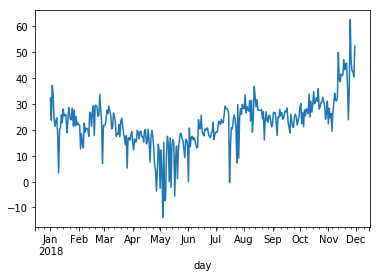

In [103]:
c12price.plot()

# Old Code follows below for potential recycling

In [ ]:
normalp.boxplot(column= 'price', by= 'hour')  # below uses showfliers=False to exclude the outliers being displayed


In [ ]:
normalp.boxplot(column= 'price', by= 'hour',showfliers=False)  # showfliers=False


In [ ]:
g= normalp.groupby('hour')
g.count()

# This seems to be saying that the three hours in November with the most frequent low prices are from 10am to 3pm
# But these 172 five-minute intervals average only 29 minutes a day of prices below $20/MWh
# Level 1 charger is normally 2 hours of charging: MAY NEED TO INCREASE THRESHOLD TO 3 CENTS/$30/MWh
# BIG QUESTION IS WHETHER THE DIFFERENCE FOR PEAK EVENING PRICES EXCEEDS 25 CENTS/KWH, OF $45/MWh (see p.17 of "Charging Smart")
# Counts can be compared to 30 days x 12 Intervals = 360 Intervals/month

In [ ]:
normalp.groupby('hour').mean()
# The lowest average prices are from 9am to 4pm, which is when Solar is strongest.

In [ ]:
spikep.price.plot(kind='hist', bins=30)

In [ ]:
normalp.price.plot(kind='hist', bins=30)  # No showfliers= False !!

In [ ]:
negativep.price.plot(kind='hist', bins=30) # excludes two outliers below -50 and an additional two below -30

WHAT IS THE QUESTION: NEED TO LIMIT HOURS TO PGE NIGHT RANGE AND COMPARE 24 INTERVALS VS 12! COMPARE PRICE DELTA

In [ ]:
normalp.price.plot(kind='hist', bins=30, cumulative= True)
# Two hours per day average for a Level One EV charger is 24 intervals x 30 days = 720: THRESHOLD must be increased!!!
# Add a horizontal red line at 720 !!
# Define a function that computes the average price (eg still below 2 cents?)

In [ ]:
# this function returns PG&E's designation of Peak (P), Off-Peak (OP), or Standard (S) EV pricing according to the hour of day
def peak(hour): 
    if hour in [24,1,2,3,4,5,6,7]:
        return 'OP'
    elif hour in [15,16,17,18,19,20,21,22]:
        return 'P'
    else:
        return 'S'
    
    

COMPREHENSIVE APPROACH TO PG&E PUBLISHED SCHEDULE
if date is a public holiday (saved as a list for 2018) OR day is weekend (Saturday/Sunday) then Peak is 3-7pm (rest Off Peak)
if day is a weekday (and not a holiday) then:
Peak is 2-9pm (hours 14 to 21)...list(range(14,22)
Partial Peak is 7am to 2pm and 9-11pm: hours 7-14 & 21-23: hour in list(range(7,15)) + list(range(21,24))
Otherwise (ELSE) 'OP' which is Off-Peak

In [ ]:
# need to enter dates as strings and make the dates datetime objects with  .to_datetime() method in pandas
holidays = ['2018-01-01','2018-01-15','2018-02-19','2018-05-28','2018-07-04','2018-09-03','2018-12-25'] #list of public holidays
holidays= pd.to_datetime(holidays) 
holidays # this works OK it seems so the Boolean should match

In [ ]:
# indentation is likely a problem as I mixed tabs and spaces!! Paste this into Spyder to debug? NOT SO! now runs!
# NB at 7am the 7th hour has just concluded, so 'PP' begins with the 8th hour
def PGE(hour,day,weekday): # hour, day, and weekday are columns from the dfp dataframe above (types listed 3 cells below)
    # need to enter dates as strings and make the dates datetime objects with  .to_datetime() method in pandas (works OK above)
    holidays = ['2018-01-01','2018-01-15','2018-02-19','2018-05-28','2018-07-04','2018-09-03','2018-12-25']
    holidays= pd.to_datetime(holidays)
    # list of public holiday
    weekend_peak= list(range(16,20)) # weekend peak is 3-7pm: noon begins hour 13, so 2pm is hour 15, 3pm is hour 16
    weekday_peak= list(range(15,23)) # this corresponds to the weekdays Monday to Friday, first for 2-9pm, for hours 15 to 8
    partial_peak= list(range(8,15)) + list(range(22,24))
    off_peak= list(range(1,8)) + [24] 
    if (day in holidays)|(weekday in ['Saturday','Sunday']):
      if hour in weekend_peak: 
        return 'P'
      else:   
        return 'OP'  
    elif hour in weekday_peak: 
      return'P'   
    elif hour in partial_peak: 
      return 'PP'  
    elif hour in off_peak:
      return 'OP'
    else:
      return 'problem!' 
      # we should never see this condition triggered unless there is a problem (hour 25 when clocks set back!)
# as a sanity check the respective lists added together should equal list(range(1,25)) so we should test with this Boolean!!
PGE(16,holidays[0],'Tuesday')

In [ ]:
list(range(1,8)) + [24]

In [ ]:
PGE(14, holidays[0], 'Monday')

In [ ]:
combined= list(range(15,23)) + list(range(8,15)) + list(range(22,24)) + list(range(1,8)) + [24] 
sorted(combined) # == list(range(1,25)) #  False!!  PROBLEM (Hmm: they match but combined is NOT horizontal but vertical!!)

In [ ]:
list(range(15,22)) + list(range(8,15)) + list(range(22,24)) + list(range(1,8)) + [24] #22

In [ ]:
list(range(7,14)) + list(range(21,22)) # test for Partial Peak ('PP')                    

In [ ]:
list(range(14,21)) # test for Peak ('PP')

In [ ]:
dfp.info()

In [ ]:
this function returns PG&E's designation of Peak (P), Off-Peak (OP), or Standard (S) EV pricing according to the hour of day
#def peak(hour): 
    if hour in [list(range(1,8) + [24]]:
       return 'OP'
   elif hour in [list(range(15,23)]:
        return 'P'
    else:
        return 'S'
   
# list comprehension version? see below

In [ ]:
d= {'OP':list(range(1,8))+ [24], 'P':list(range(15,23)),'S':list(range(8,15)) + list(range(22,24))}
def PGE(hour):
    for key,value in d.items:
        if hour in d.value  #FIX THIS
            return d.key
print(PGE(3))

In [ ]:
peak(1)
peak(16)

In [ ]:
dfp['PGE']= dfp.hour.apply(peak)
dfp.PGE.head()
dfp.PGE.tail()

In [ ]:
dfp.head()

In [ ]:
gPGE= dfp.groupby(['day','PGE'])

In [ ]:
daily_PGE= gPGE.price.mean() # this is hourly data!!
daily_PGE.head(20)

In [ ]:
dfPGE= daily_PGE.to_frame()
dfPGE= dfPGE.sort_values(['day'])
dfPGE.head()

In [ ]:
dfPGE.tail() # 

In [ ]:
dfPGE= dfPGE.unstack('PGE')
dfPGE.head()

In [ ]:
FebPGE = dfPGE.loc['2018-02-01':'2018-02-28'].plot()# so a peak of $140/MWh is 14 cents
FebPGE.plot()

In [ ]:
MarPGE = dfPGE.loc['2018-03-01':'2018-03-31'] # so a peak of $140/MWh is 14 cents
MarPGE.plot()

In [ ]:
AprPGE= dfPGE.loc['2018-04-01':'2018-04-30'] # so a peak of $140/MWh is 14 cents
AprPGE.plot()

In [ ]:
dfPGE.plot() 
# THIS IS A CRITICAL PLOT TO BE REPEATED MONTHLY USING A PANEL APPROACH (can use df.loc() or extract 'month' as a variable)
# Surprises: the highest spikes are not Peak but Standard, 
# peak is evening from 2pm to 8pm!
# Peak seems to have recurring spikes perhaps related to the day of the week?
# on many days the standard price is below the off-peak price Can calculate frequency with a Boolean!
# Standard is from 8 until 2pm so prices are lowered by midday solar

In [ ]:
dfPGE.info()

In [ ]:
dfPGE.columns= ['OP','P','S']
dfPGE.head(3)
dfPGE.tail()

In [ ]:
# BIG QUESTION: EACH DAY FIND THE HIGHEST 100 PRICES AND THEN THE LOWEST 100 PRICES VIA SORT. 
# THEN SUBTRACT THE LOWEST FROM THE HIGHEST, AND SEE IF > $0.25. KEEP GOING UNTIL THIS THRESHOLD IS HIT! 
# SO CHARGE AT WORK FROM 9 TO 10AM AND USE AT HOME TO RUN AC IN PEAK HOURS!!!

In [ ]:
# We need suppose 2 hours on average daily, 24 intervals/day, 720/month. Find for cumulative of 720 the cut-off price
# Then calculate the average price (of course less than cutoff): compute for 720 vs 360, and annnualise cost benefit
# this is the economic value of the Level 2 Charger versus the Level 1.

In [ ]:
# downsample the 5-minute prices to hourly and match up with hourly wind and solar data (Dhavide Course One)